In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.stats import linregress
from utils import plots, plots_survival
%matplotlib inline

Load merged datasheet (Vasari, Midline Shift Quantifications, Imaging Features, Clinical Data)

In [2]:
merged_data = pd.read_csv("datasheets/cleaned_merged.csv")

merged_data.head()

# vasari_list = [key for key in merged_data.keys() if "vasari" in key.lower() and any(['text_report', 'region_proportions'])]
vasari_list = [k for k in merged_data if "vasari" in k.lower() and not any(s in k.lower() for s in ["text_report", "region_proportions"])]
midline_shift = ['brats23_metadata_flattened__global__max_midline_shift_mm', 'midline_summary__mean_distance_mm', 'midline_summary__p95_distance_mm', 'brats23_metadata_flattened__global__level_max_shift']
mutation_status = [key for key in merged_data.keys() if any(s in key.lower() for s in ["mgmt_status", "idh_status"])]
brats_masks = ["GBM_Subjects_Spreadsheet__nr_volume", "GBM_Subjects_Spreadsheet__er_volume" , "GBM_Subjects_Spreadsheet__et_volume" , "GBM_Subjects_Spreadsheet__tumor_volume" , "GBM_Subjects_Spreadsheet__tumor_burden" , "GBM_Subjects_Spreadsheet__etiv", "GBM_Subjects_Spreadsheet__resection_status"]
demo_list = ["GBM_Subjects_Spreadsheet__age" , "GBM_Subjects_Spreadsheet__sex", "UCSF-PDGM-Clinical__Final pathologic diagnosis (WHO 2021)"]

merged_data["event"] = 1 

merged_data["GBM_Subjects_Spreadsheet__sex"] = [bool(x) for x in merged_data["GBM_Subjects_Spreadsheet__sex"]-1]
merged_data["GBM_Subjects_Spreadsheet__sex"] = [
    "Male" if bool(x) else "Female" for x in (merged_data["GBM_Subjects_Spreadsheet__sex"] - 1)
]


merged_data['GBM_Subjects_Spreadsheet__mgmt_status'] = [
    "Methylated" if bool(x) else "Unmethylated" for x in (merged_data["GBM_Subjects_Spreadsheet__mgmt_status"])
]

merged_data['GBM_Subjects_Spreadsheet__idh_status'] = [
    "Mutant" if bool(x) else "Wildtype" for x in (merged_data["GBM_Subjects_Spreadsheet__idh_status"])
]

merged_data['GBM_Subjects_Spreadsheet__resection_status'] = [
    "Gross Total Resection (>90%)" if bool(x) else "Biopsy/Subtotal Resection (<90%)" for x in (merged_data["GBM_Subjects_Spreadsheet__resection_status"])
]

merged_data['brats23_metadata_flattened__global__max_midline_shift_mm'] = [abs(x) for x in merged_data['brats23_metadata_flattened__global__max_midline_shift_mm']]

VASARI Features

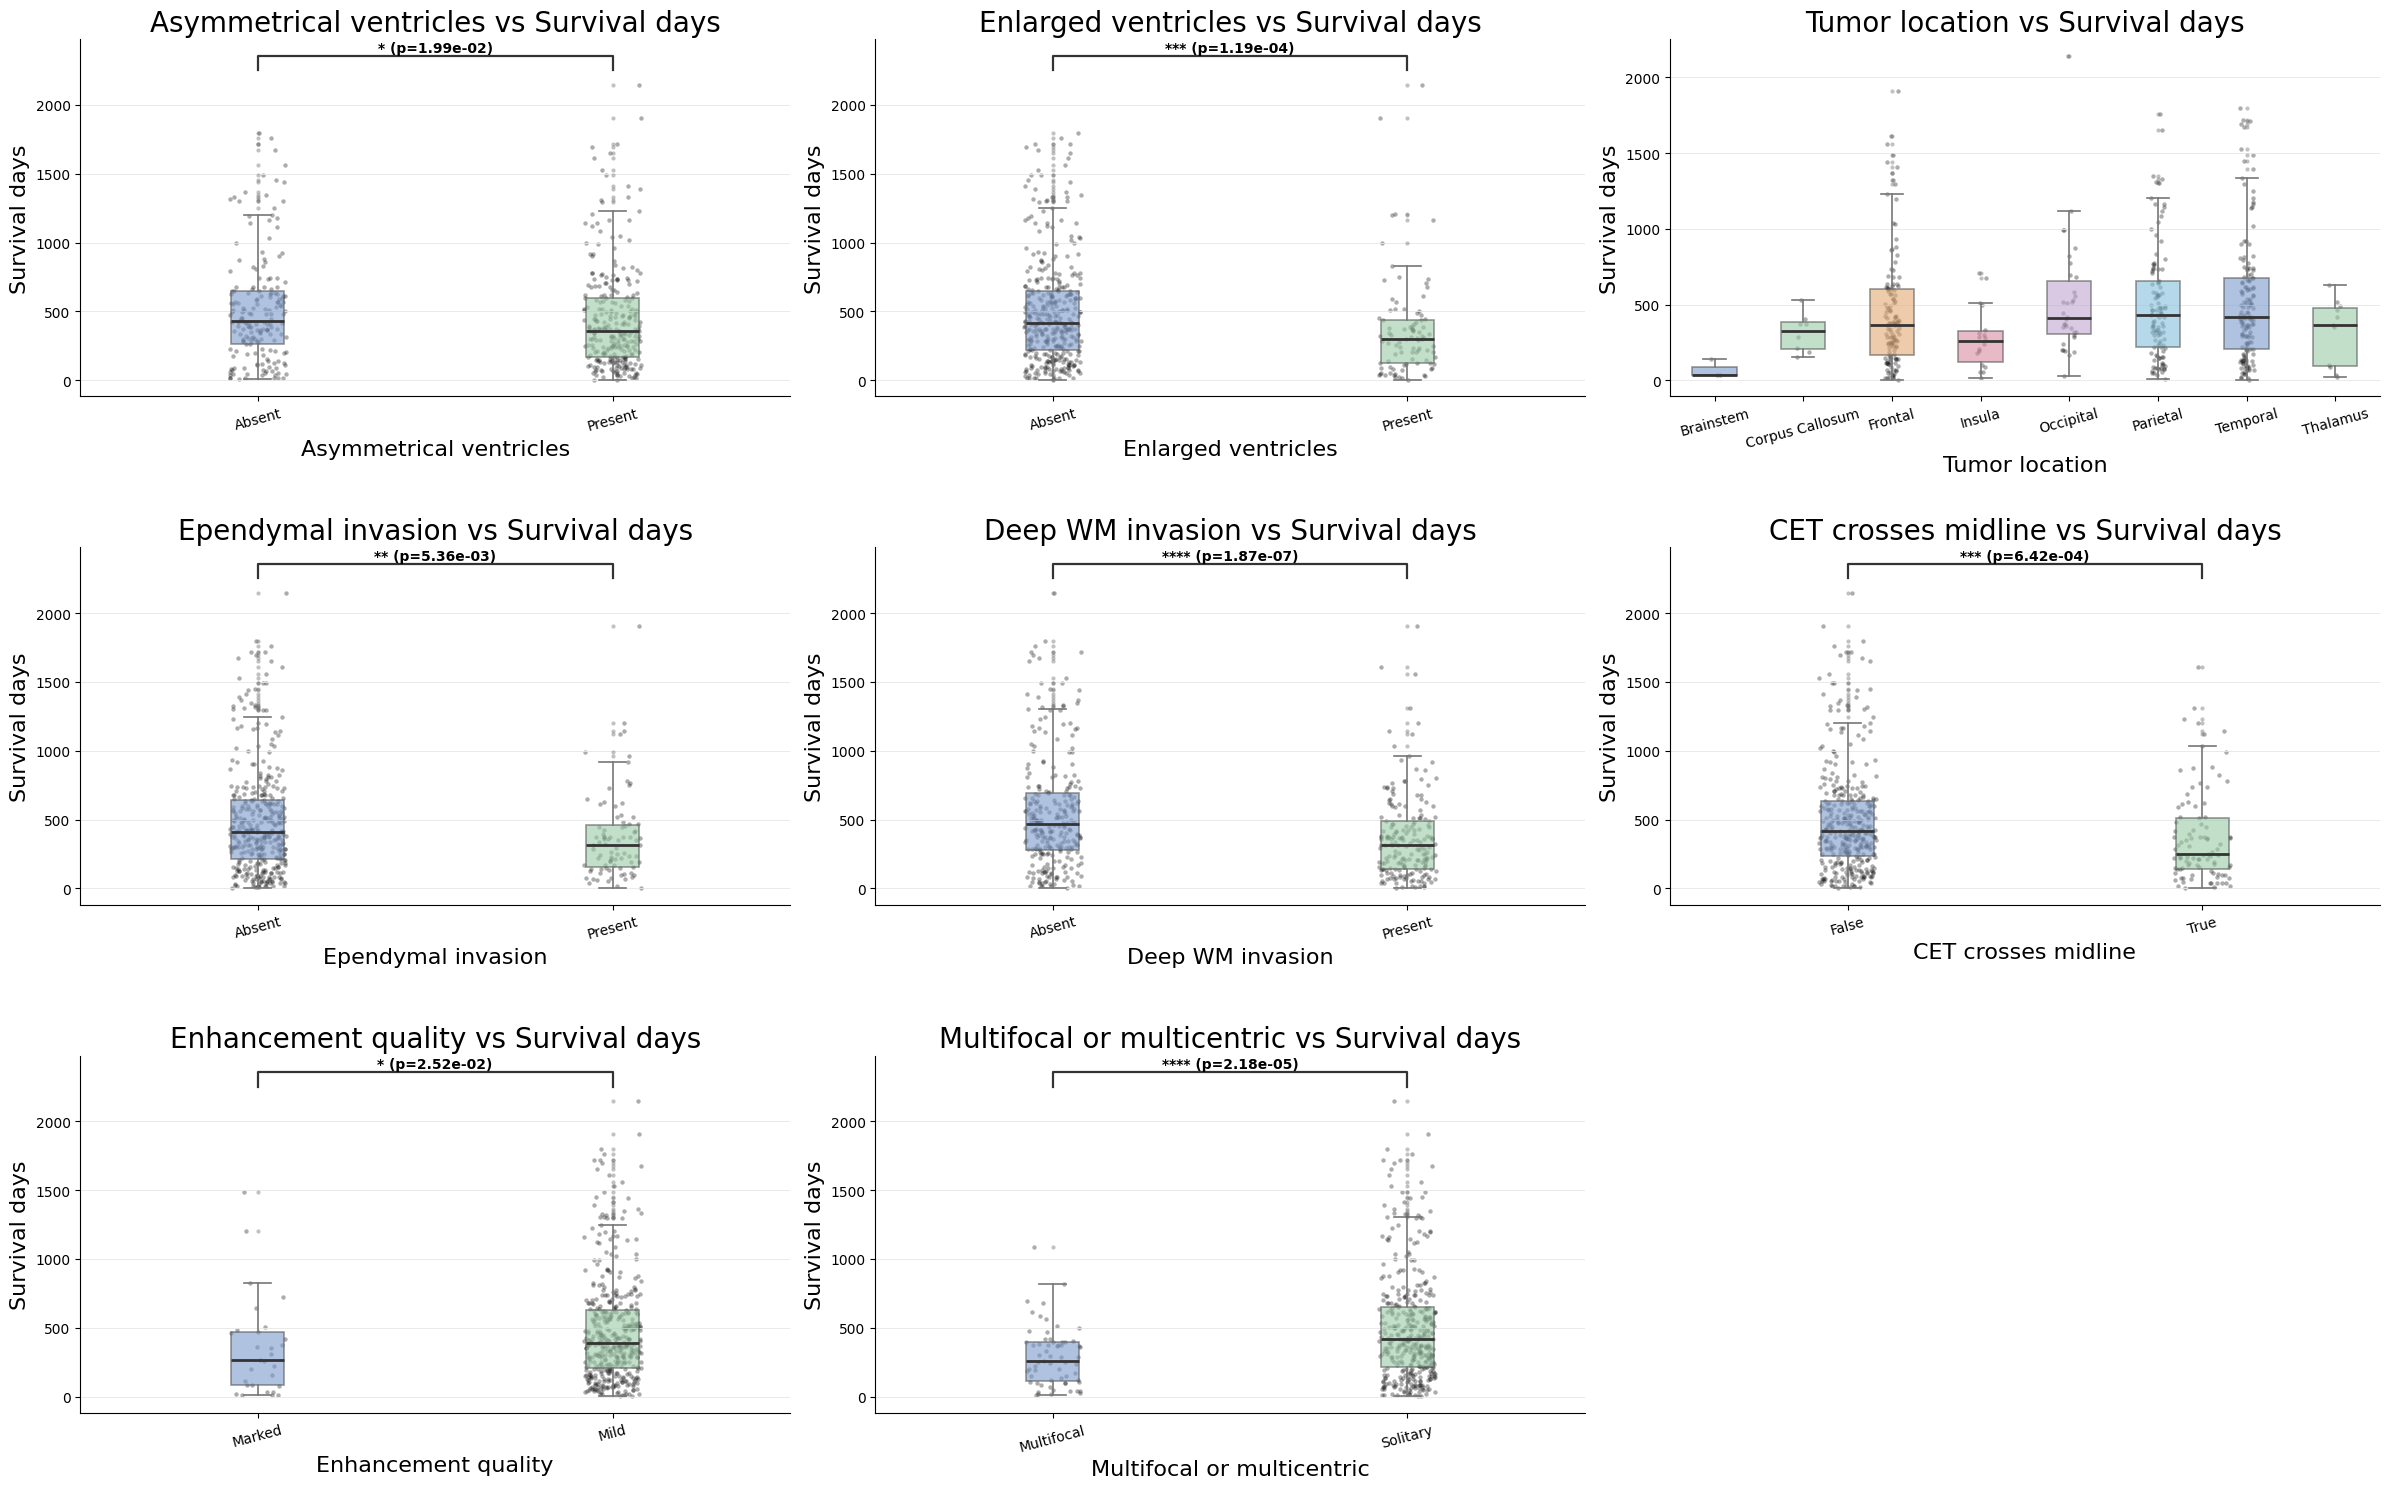

In [3]:
plots(df=merged_data,x_list=vasari_list, only_significant=True)


BraTS Segmentation Features

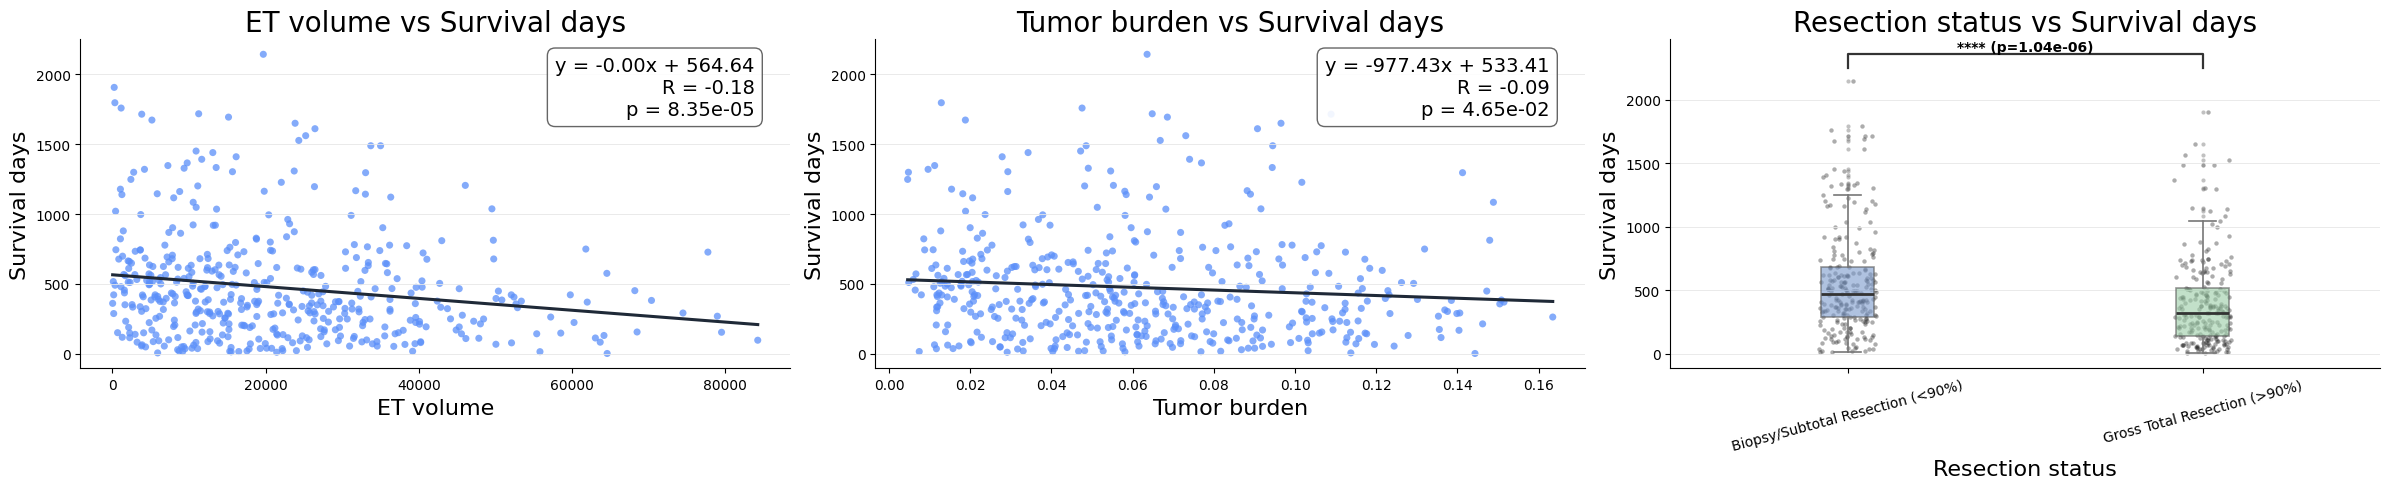

In [4]:
plots(df=merged_data,x_list=brats_masks, only_significant=True)

Patient Demographics

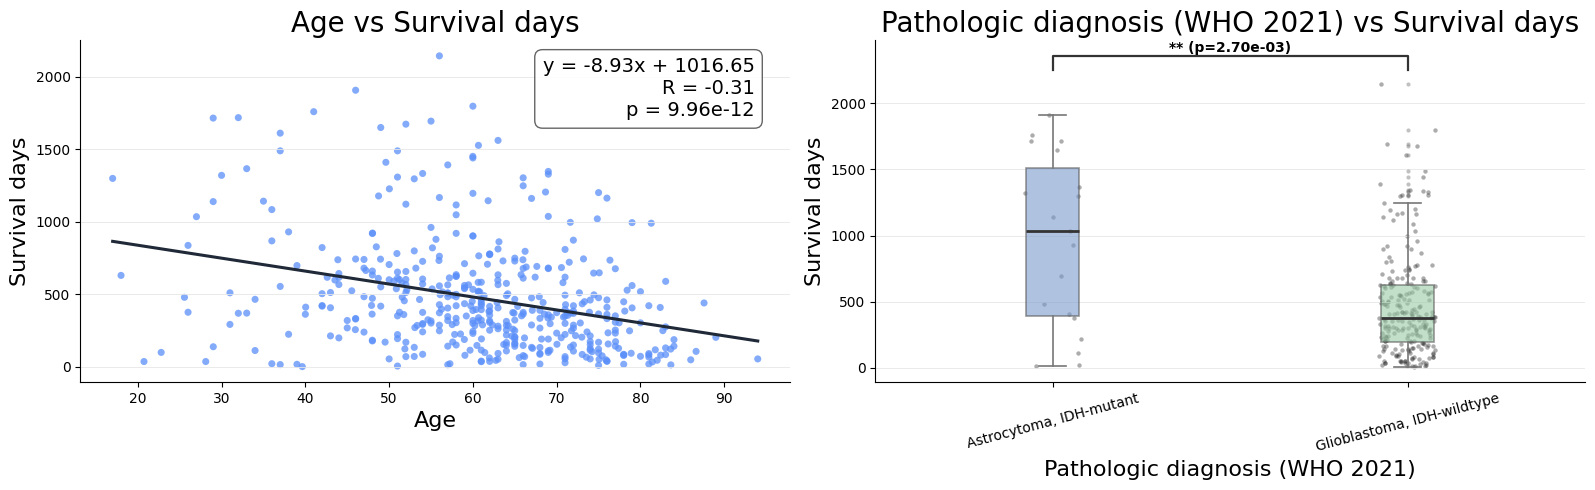

In [5]:
plots(df=merged_data,x_list=demo_list, only_significant=True)


Mutation Status

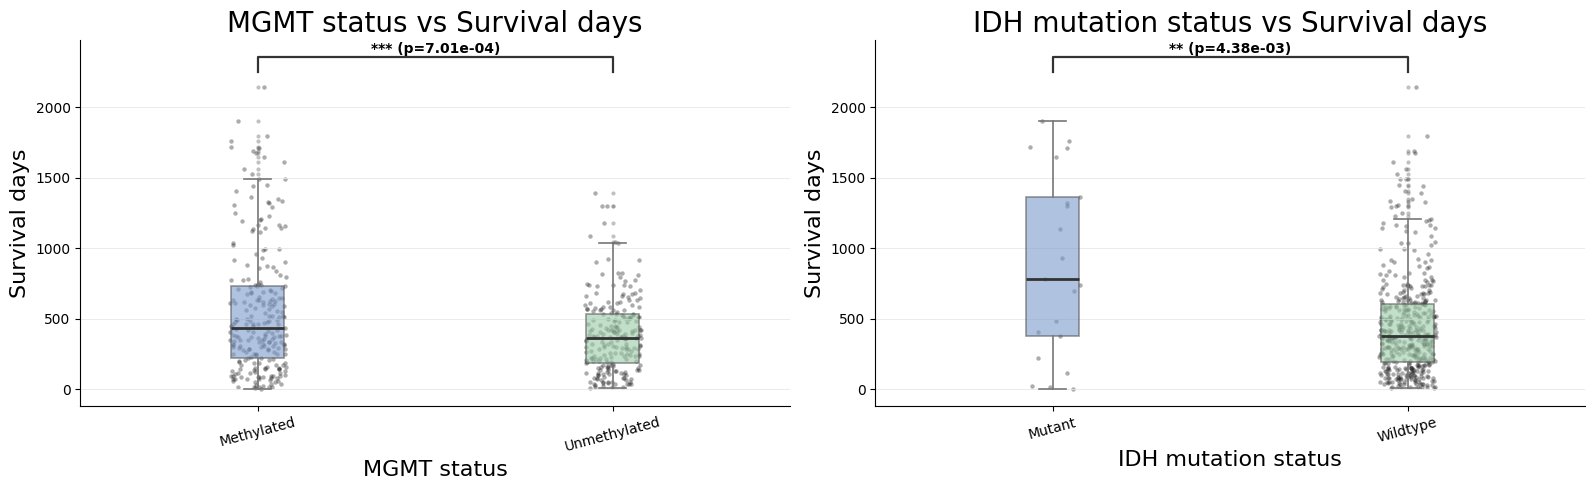

In [6]:
plots(df=merged_data,x_list=mutation_status,only_significant=True) 

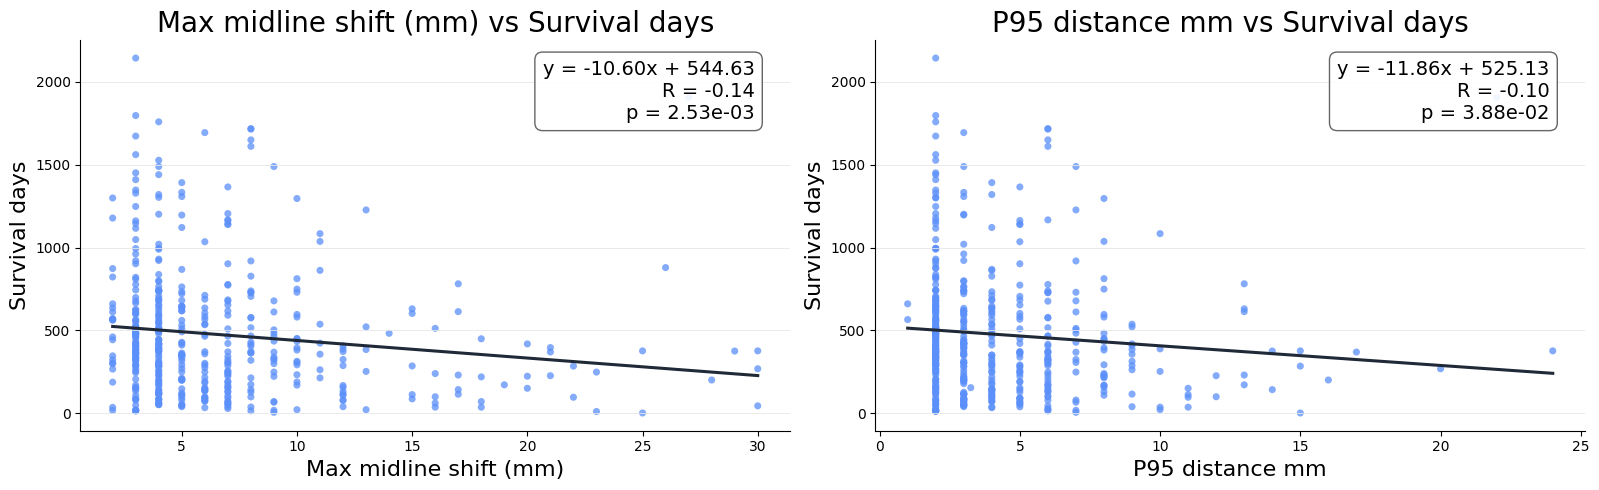

In [7]:
plots(df=merged_data,x_list=midline_shift,only_significant=True)

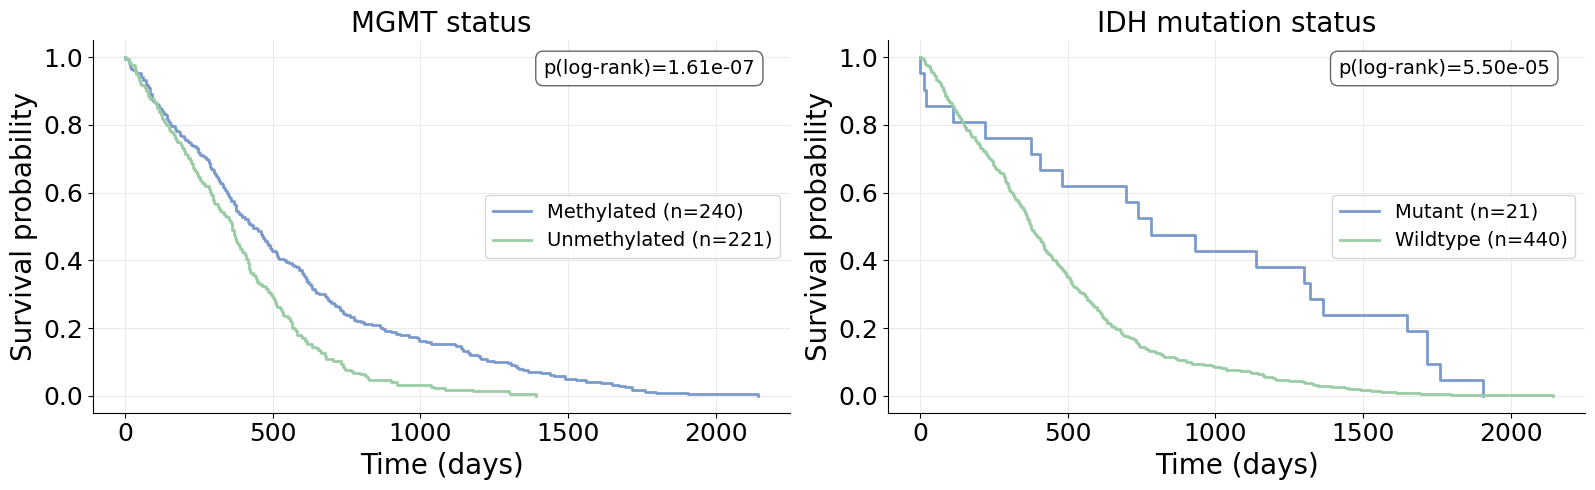

In [8]:
plots_survival(
    df=merged_data,
    x_list=mutation_status,
    only_significant=True, alpha=0.01,
    save_path='./assets/mutation_vs_surv_KM.png',
)

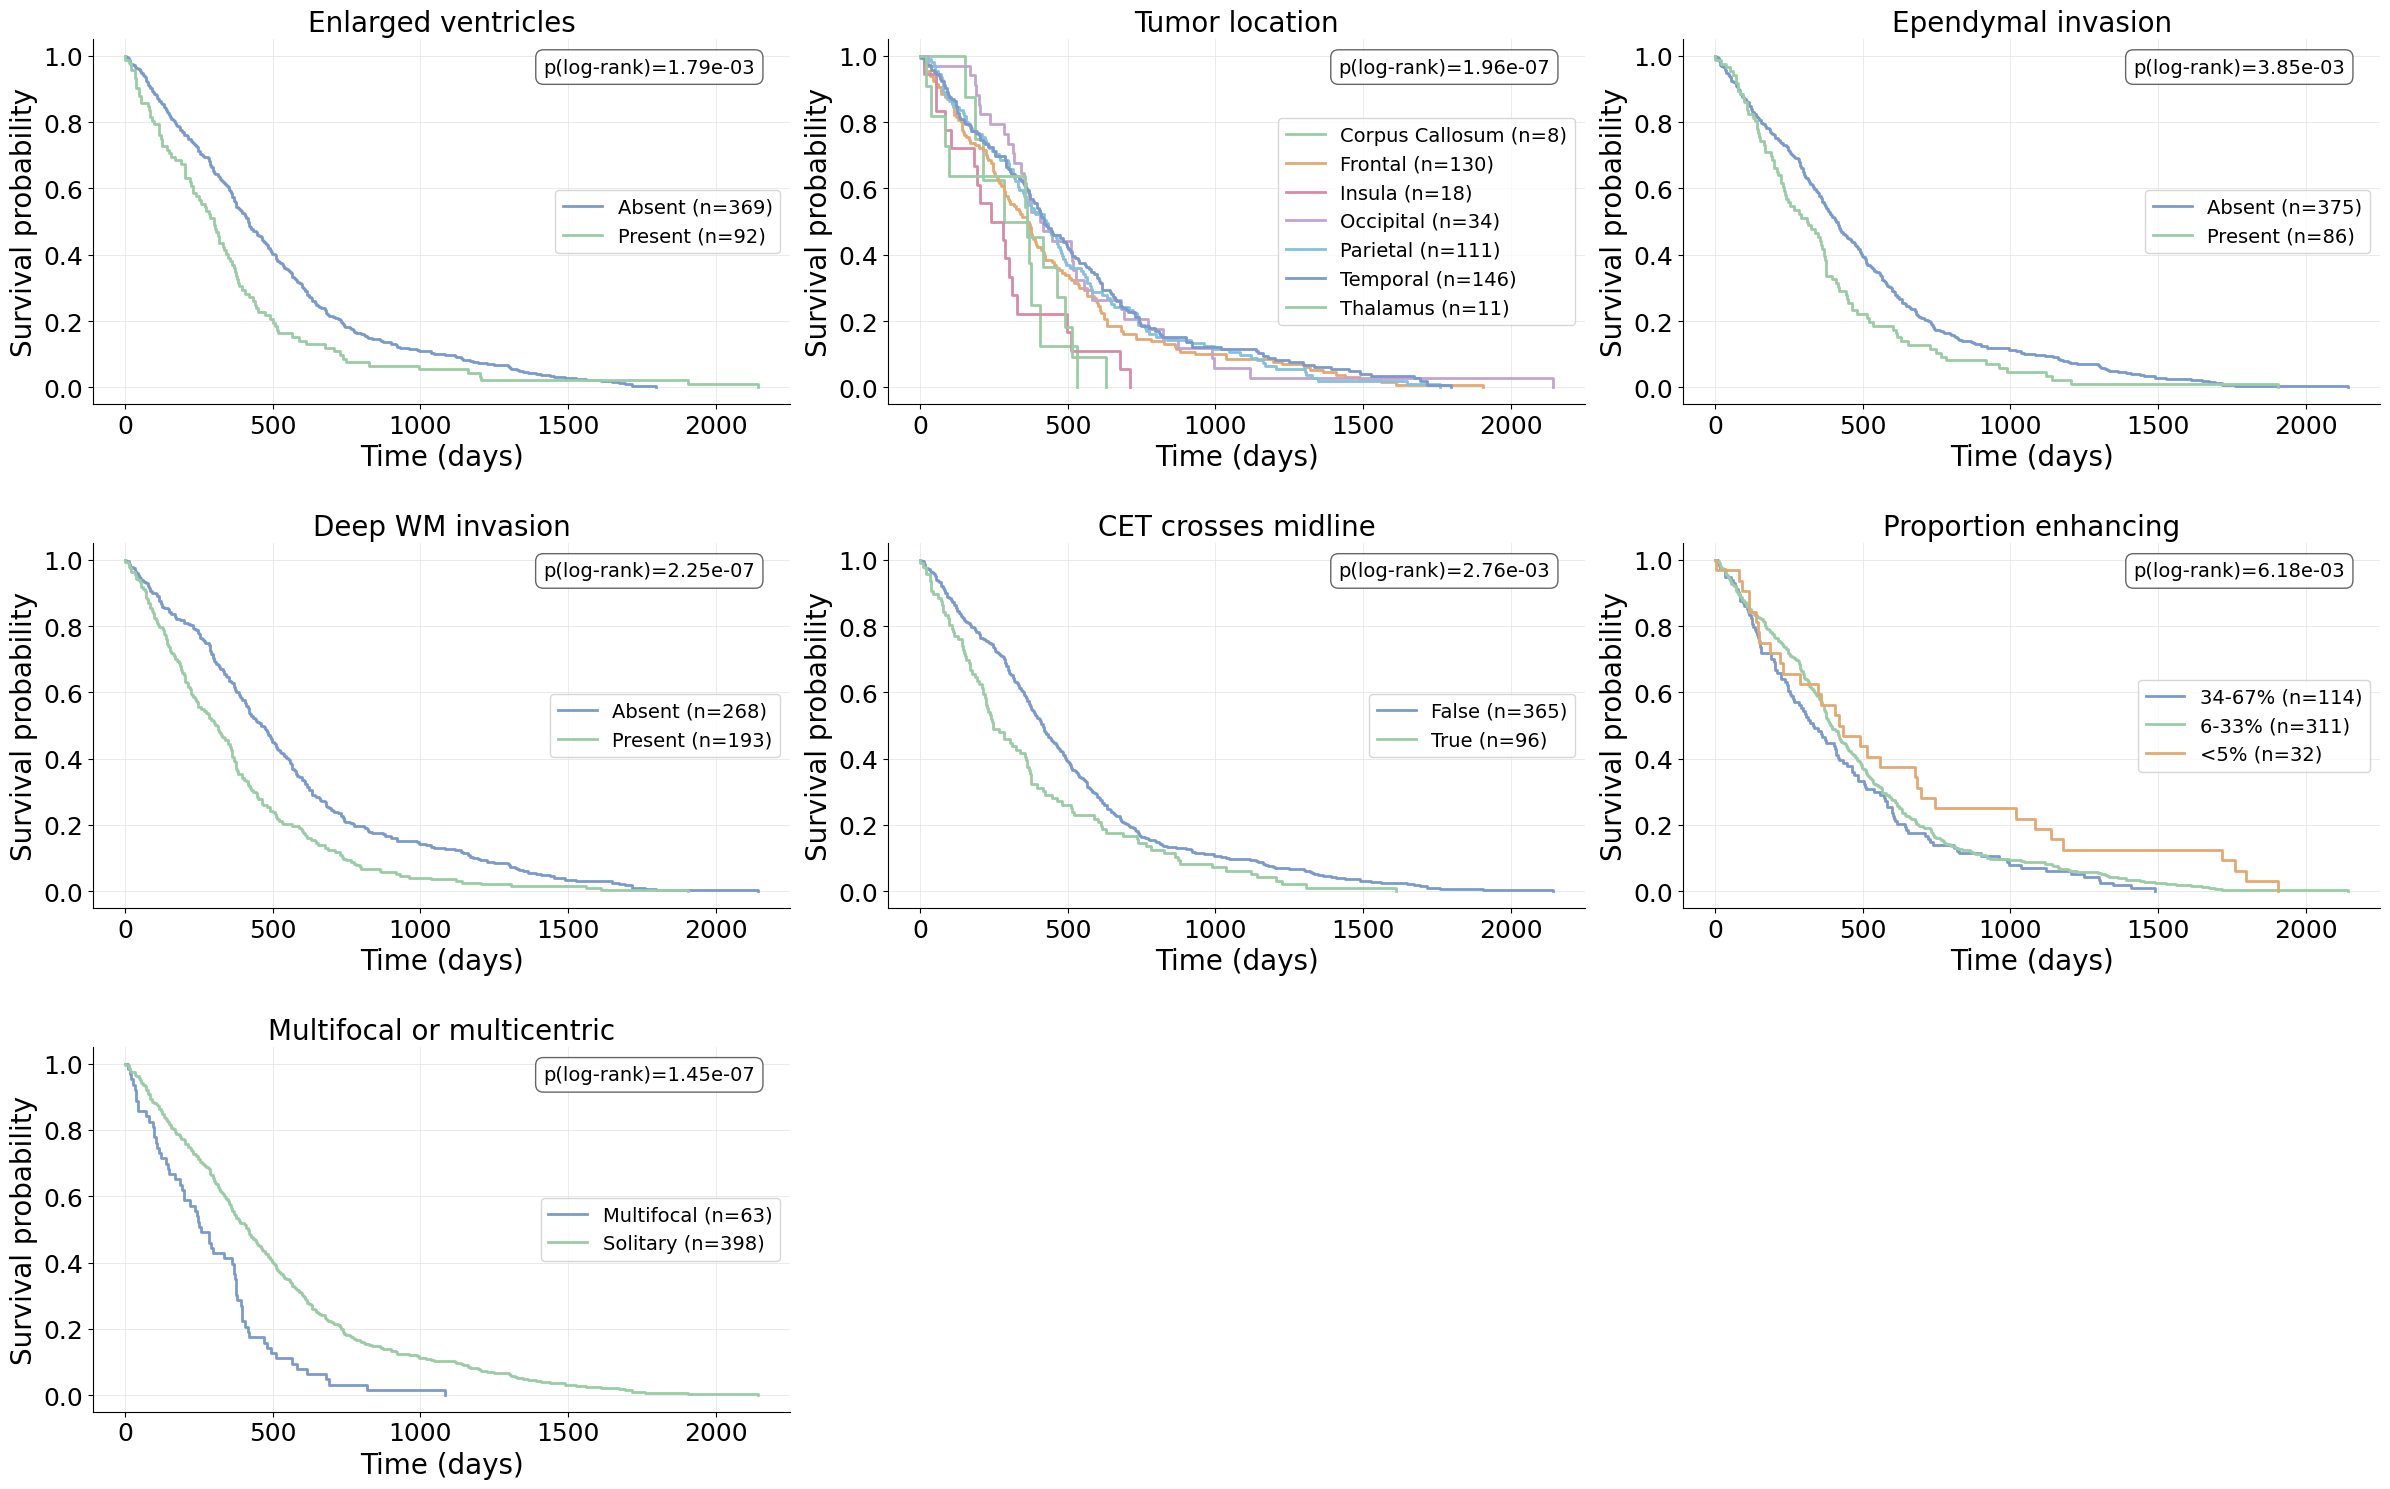

In [9]:
plots_survival(df=merged_data,x_list=vasari_list, only_significant=True, alpha=0.01, save_path='./assets/vasari_vs_surv_KM.png',)


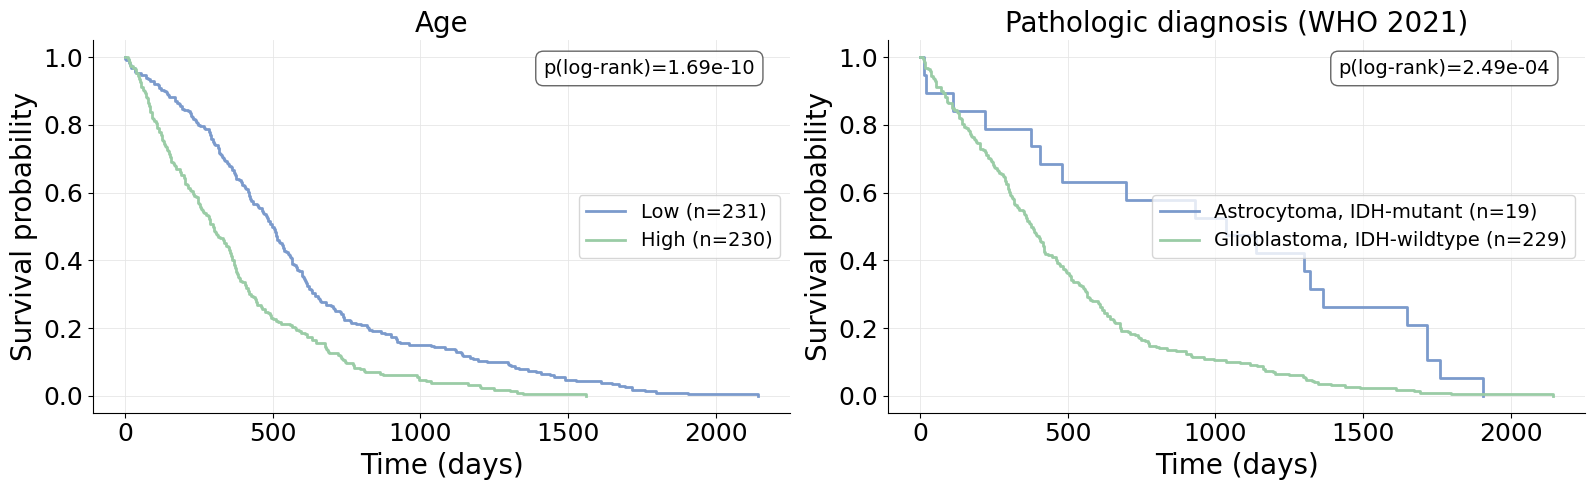

In [10]:
plots_survival(df=merged_data,x_list=demo_list, only_significant=True, alpha=0.01, save_path='./assets/demographics_vs_surv_KM.png',)


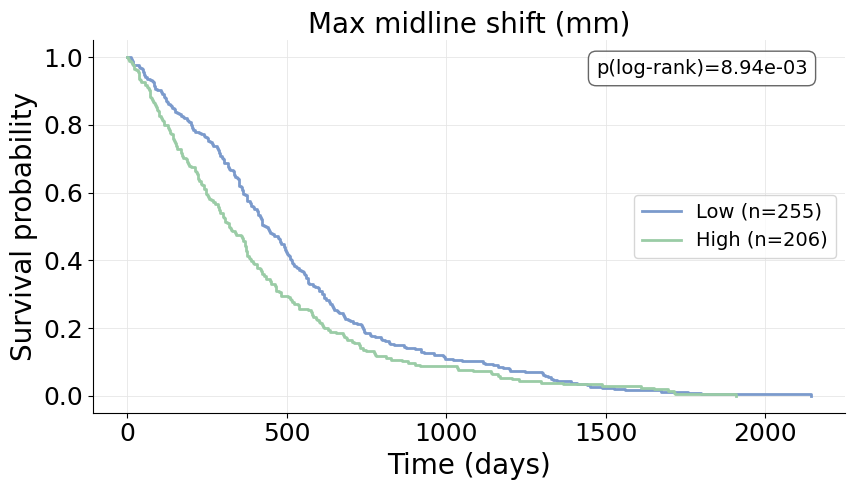

In [11]:
plots_survival(df=merged_data,x_list=midline_shift,only_significant=True, alpha=0.01,save_path='./assets/midline_vs_surv_KM.png',)

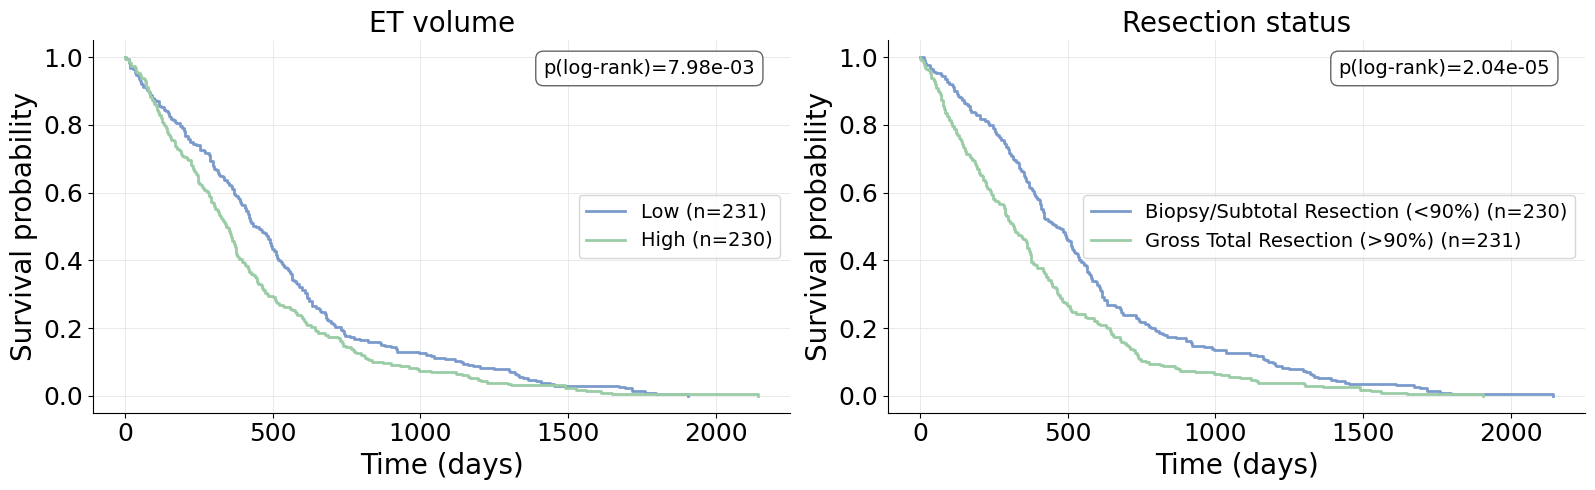

In [12]:
plots_survival(df=merged_data,x_list=brats_masks, only_significant=True, alpha=0.01,save_path='./assets/lesionstats_vs_surv_KM.png',)

['brats23_metadata_flattened__global__vasari_asymmetrical_ventricles', 'brats23_metadata_flattened__global__vasari_enlarged_ventricles', 'brats23_metadata_flattened__global__vasari_f1_tumour_location', 'brats23_metadata_flattened__global__vasari_f11_thickness_of_enhancing_margin', 'brats23_metadata_flattened__global__vasari_f14_proportion_of_oedema', 'brats23_metadata_flattened__global__vasari_f19_ependymal_invasion', 'brats23_metadata_flattened__global__vasari_f2_side_of_tumour_epicenter', 'brats23_metadata_flattened__global__vasari_f20_cortical_involvement', 'brats23_metadata_flattened__global__vasari_f21_deep_wm_invasion', 'brats23_metadata_flattened__global__vasari_f23_cet_crosses_midline', 'brats23_metadata_flattened__global__vasari_f24_satellites', 'brats23_metadata_flattened__global__vasari_f3_eloquent_brain', 'brats23_metadata_flattened__global__vasari_f4_enhancement_quality', 'brats23_metadata_flattened__global__vasari_f5_proportion_enhancing', 'brats23_metadata_flattened__glo

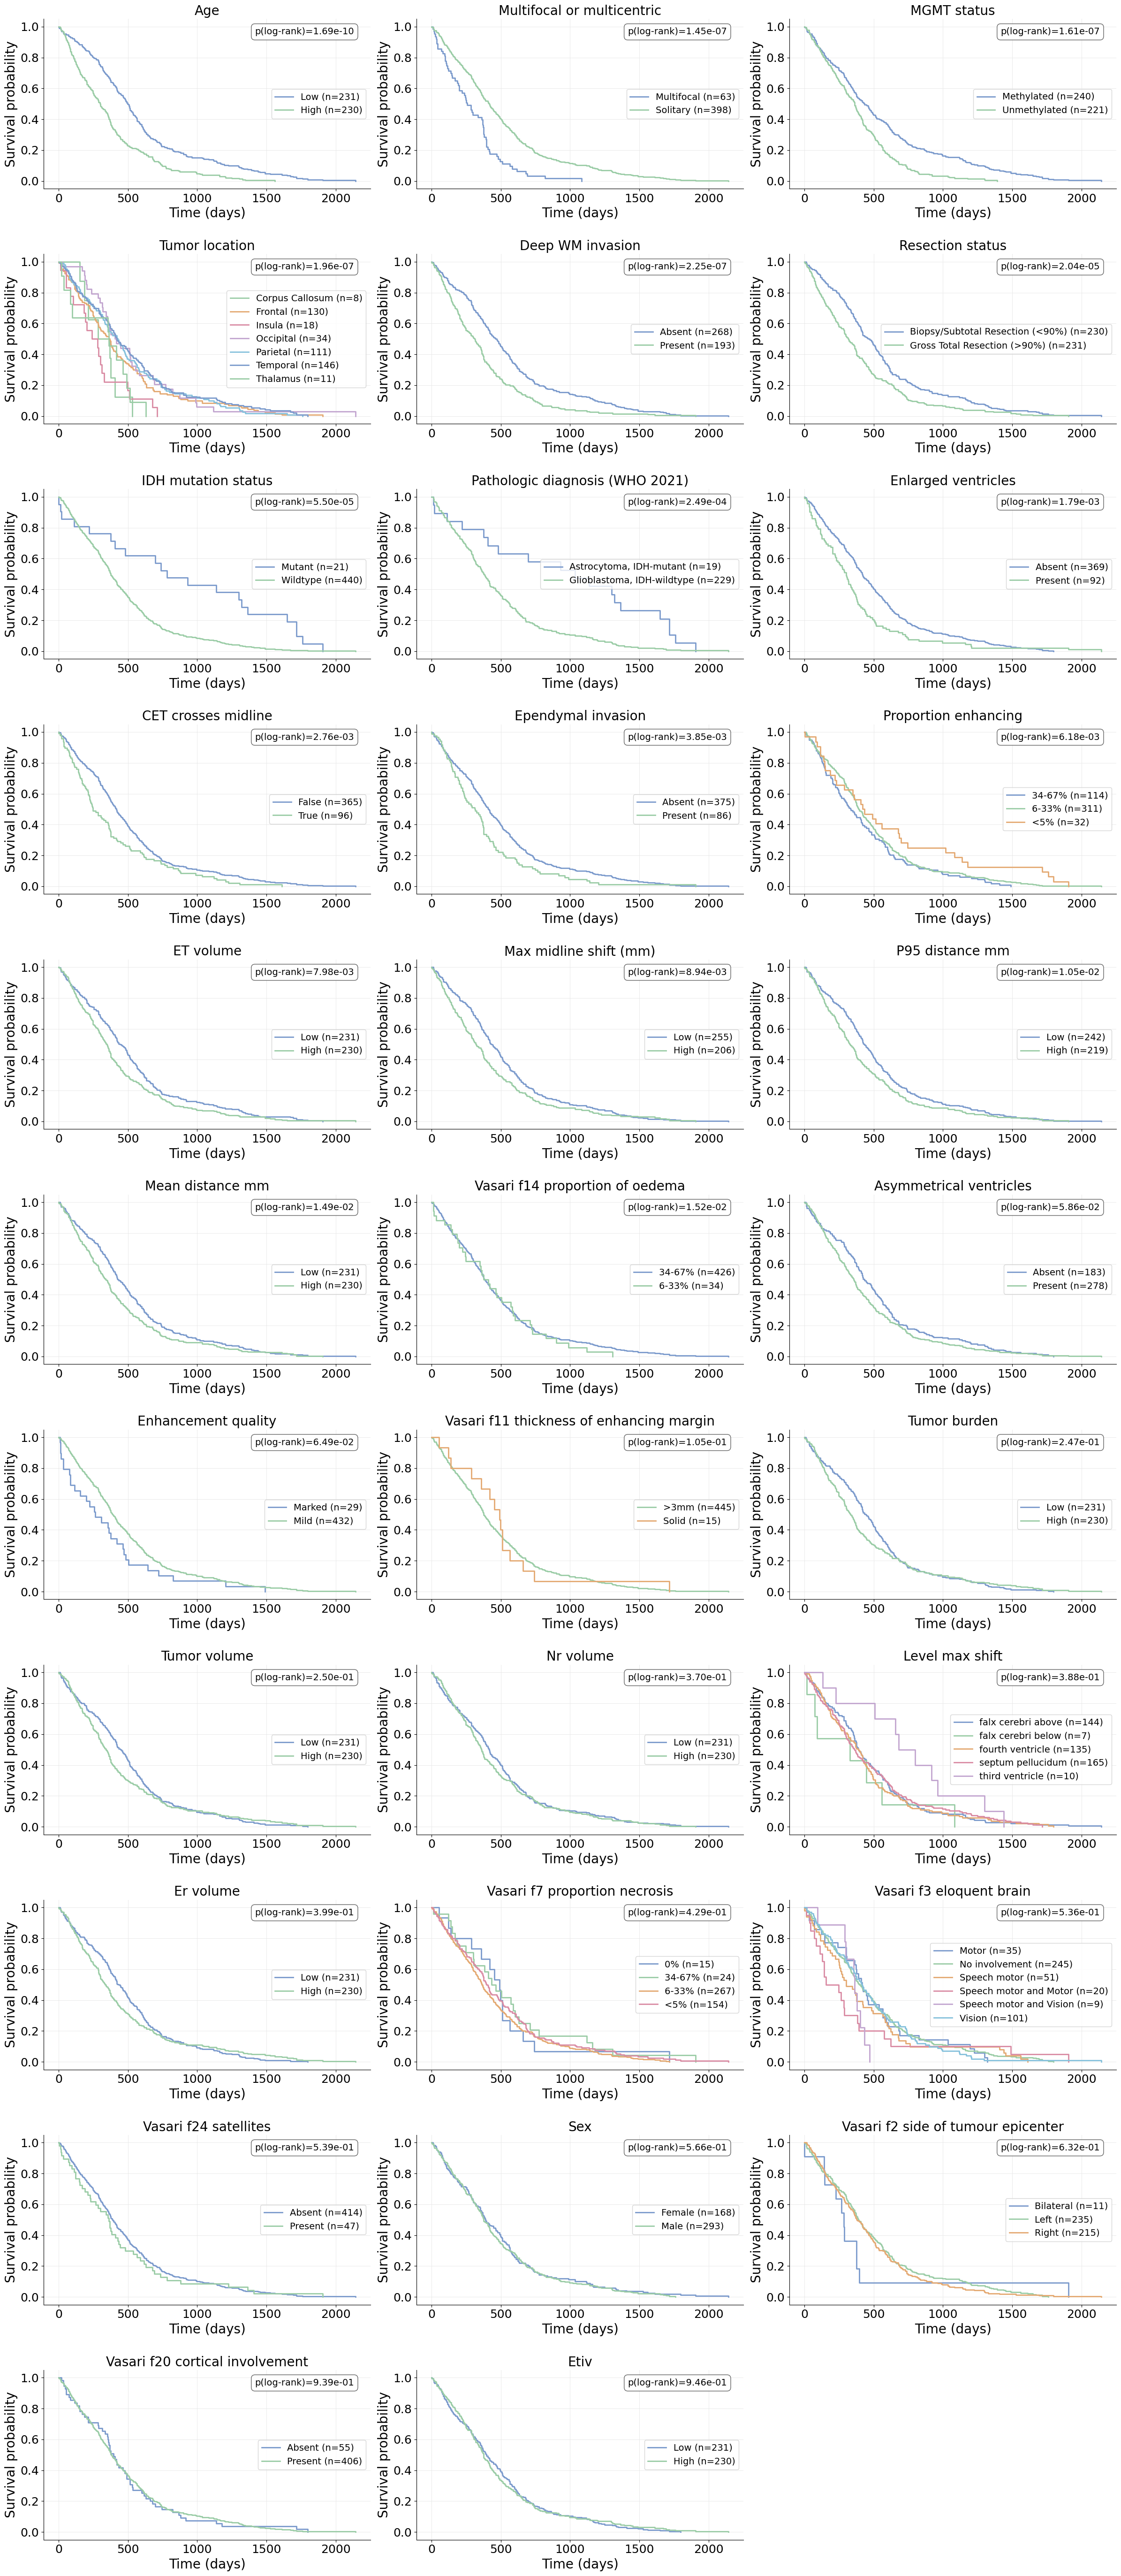

In [13]:
features=vasari_list+ midline_shift+ mutation_status+ brats_masks+demo_list
print(features)
plots_survival(df=merged_data,x_list=features, only_significant=False, alpha=0.05,save_path='./assets/all_vs_surv_KM.png',sort=True)

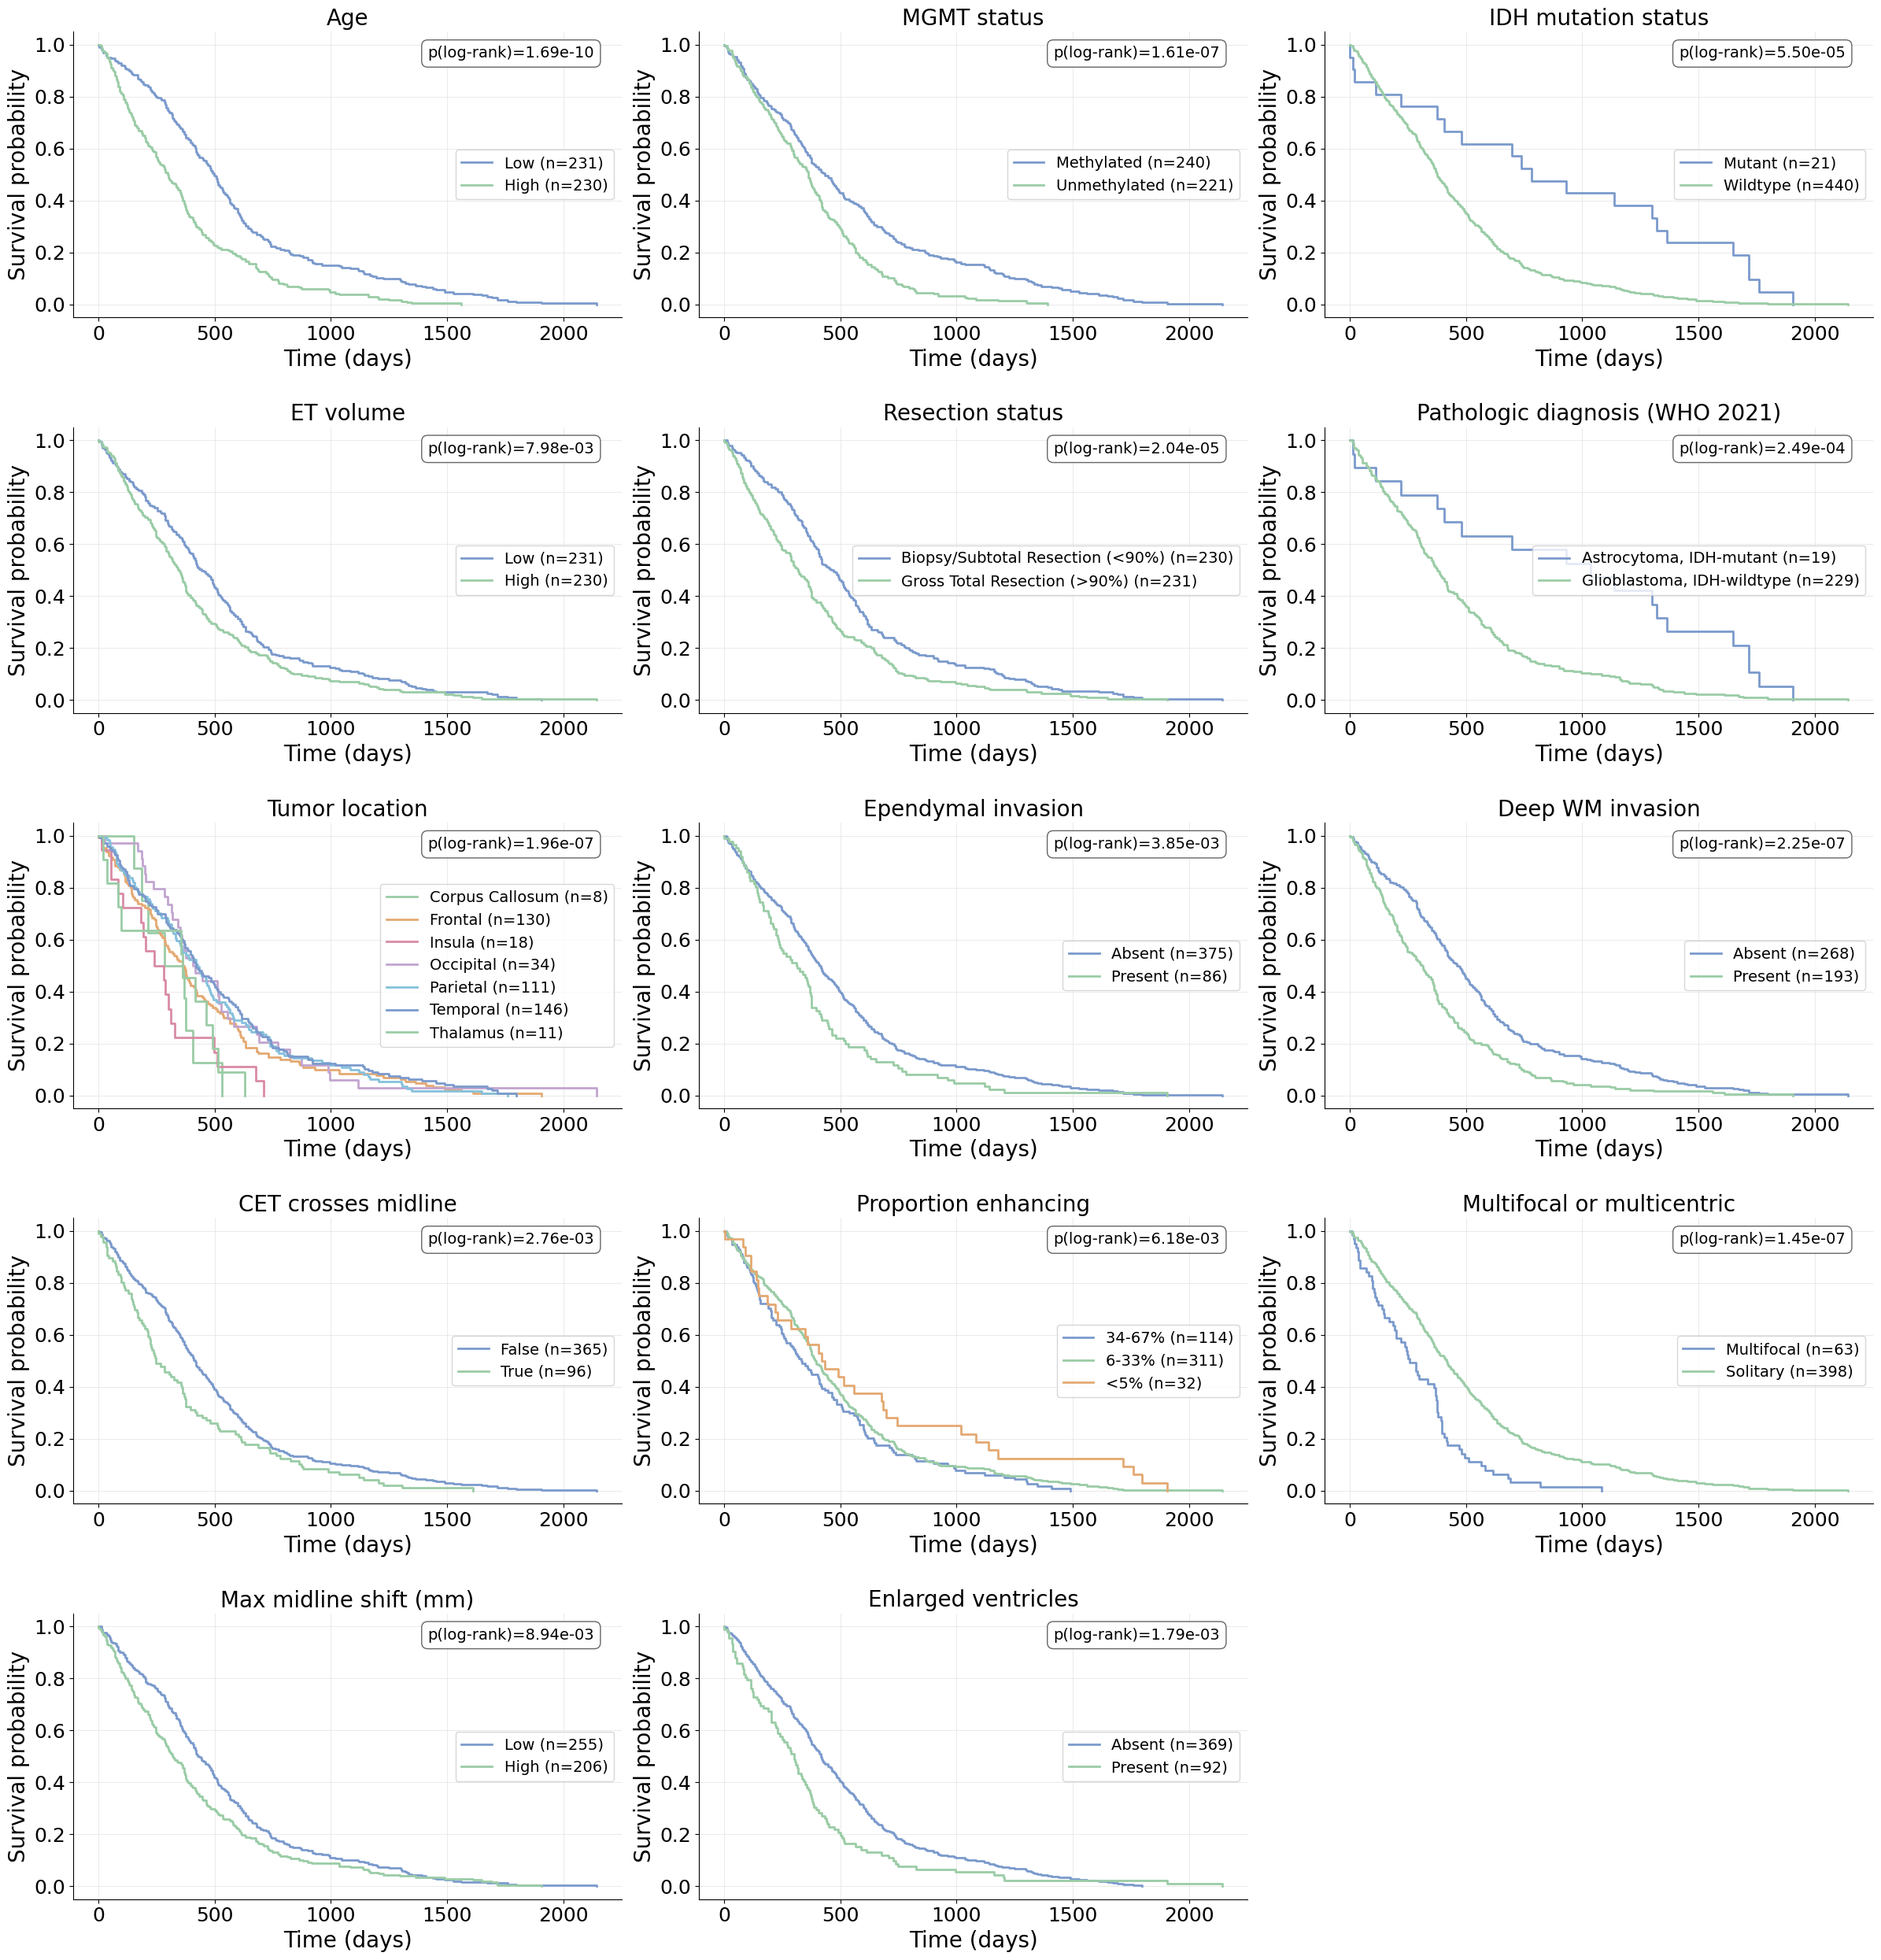

In [14]:
features=[
'GBM_Subjects_Spreadsheet__age',
'GBM_Subjects_Spreadsheet__mgmt_status',
'GBM_Subjects_Spreadsheet__idh_status',
'GBM_Subjects_Spreadsheet__et_volume',
'GBM_Subjects_Spreadsheet__resection_status',
'UCSF-PDGM-Clinical__Final pathologic diagnosis (WHO 2021)',

 'brats23_metadata_flattened__global__vasari_f1_tumour_location',
 'brats23_metadata_flattened__global__vasari_f19_ependymal_invasion',
 'brats23_metadata_flattened__global__vasari_f21_deep_wm_invasion',
 'brats23_metadata_flattened__global__vasari_f23_cet_crosses_midline',
 'brats23_metadata_flattened__global__vasari_f5_proportion_enhancing',
 'brats23_metadata_flattened__global__vasari_f9_multifocal_or_multicentric',

'brats23_metadata_flattened__global__max_midline_shift_mm',
'brats23_metadata_flattened__global__level_max_shift',
'brats23_metadata_flattened__global__vasari_enlarged_ventricles',

]
plots_survival(df=merged_data,x_list=features, only_significant=True, alpha=0.05,save_path='../assets/allsig_vs_surv_KM.png',)